In [2]:
from qpe import *
from numpy import log, ones, full

import qutip as qp
from time import time

from numpy import sign, ceil
from numpy.random import randint

from scipy.stats import unitary_group, gaussian_kde
from scipy.linalg import logm

import pickle

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family']='serif'
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rc('text', usetex=True)

# QCNN

In [3]:
def rzzyyxx(N, q1, q2, pars):
    d = 2**N
    j, k = sorted([q1, q2])
    c0, s0 = cos(pars[0]), sin((pars[0]))
    c1, s1 = cos(pars[1]), sin((pars[1]))
    c2, s2 = cos(pars[2]), sin((pars[2]))
    coeff_II = c0*c1*c2 - 1j*s0*s1*s2
    coeff_XX = c0*s1*s2 - 1j*s0*c1*c2
    coeff_YY = s0*c1*s2 - 1j*c0*s1*c2
    coeff_ZZ = s0*s1*c2 - 1j*c0*c1*s2
    term_II = diag(full(d, coeff_II))
    term_XX_1 = kron_N_A(X, 2**j)
    term_XX_1 = kron_A_N(term_XX_1, 2**(k - j - 1))
    term_XX_2 = kron_A_N(X, 2**(N - k - 1))
    term_XX = coeff_XX*fkron(term_XX_1, term_XX_2)
    term_YY_1 = kron_N_A(Y, 2**j)
    term_YY_1 = kron_A_N(term_YY_1, 2**(k - j - 1))
    term_YY_2 = kron_A_N(Y, 2**(N - k - 1))
    term_YY = coeff_YY*fkron(term_YY_1, term_YY_2)
    term_ZZ_1 = kron_N_A(Z, 2**j)
    term_ZZ_1 = kron_A_N(term_ZZ_1, 2**(k - j - 1))
    term_ZZ_2 = kron_A_N(Z, 2**(N - k - 1))
    term_ZZ = coeff_ZZ*fkron(term_ZZ_1, term_ZZ_2)
    return term_II + term_XX + term_YY + term_ZZ
    
def su4(N, q1, q2, pars):
    d = 2**N
    j, k = sorted([q1, q2])
    term_11 = kron_N_A(su2(pars[0:3]), 2**j)
    term_11 = kron_A_N(term_11, 2**(k - j - 1))
    term_12 = kron_A_N(su2(pars[3:6]), 2**(N - k - 1))
    term_1 = fkron(term_11, term_12)
    term_2 = rzzyyxx(N, q1, q2, pars[6:9])
    term_31 = kron_N_A(su2(pars[9:12]), 2**j)
    term_31 = kron_A_N(term_31, 2**(k - j - 1))
    term_32 = kron_A_N(su2(pars[12:15]), 2**(N - k - 1))
    term_3 = fkron(term_31, term_32)
    return term_3@term_2@term_1

def schw_pool(N, q1, q2, pars):
    d = 2**N
    j, k = sorted([q1, q2])
    su2_1 = su2(pars[0:3])
    su2_2 = su2(pars[3:6])
    term_11 = kron_N_A(su2_1, 2**j)
    term_11 = kron_A_N(term_11, 2**(k - j - 1))
    term_12 = kron_A_N(su2_2, 2**(N - k - 1))
    term_1 = fkron(term_11, term_12)
    term_2 = kron_N_A(su2_1.conj().T, 2**k)
    term_2 = kron_A_N(term_2, 2**(N - k - 1))
    return term_2@cx(N, q1, q2)@term_1

def qcnn_schwinger(N, pars):
    """ 
        Taken from https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.5.043250
        Guarantied to work for N = 2**integer :) 
    """
    L = int(log2(N))
    it = iter(pars)
    op = eye(2**N)
    for l in range(L):
        # print("\tconv:")
        for a in arange(0, N, 2**(l + 1)):
            # print("\t\t", a, a + 2**l)
            pars_cur = [next(it) for _ in range(15)]
            # print(pars_cur)
            op = su4(N, a, a+2**l, pars_cur)@op
        for a in arange(0, N - 2**(l + 1), 2**(l + 1)):
            # print("\t\t", a + l + 1, a + 2**l + l + 1)
            pars_cur = [next(it) for _ in range(15)]
            # print(pars_cur)
            op = su4(N, a+l+1, a+2**l+l+1, pars_cur)@op
        # print("\tpool:")
        for a in arange(0, N, 2**(l + 1)):
            # print("\t\t", a, a + 2**l)
            pars_cur = [next(it) for _ in range(6)]
            # print(pars_cur)
            op = schw_pool(N, a, a+2**l, pars_cur)@op
    return op

In [140]:
def train_qcnn_cfi(ham_func, ham_pars, ham_args, n_inp, n_meas_list=None, n_copies=1, method="BFGS", x0=None, options={}, fvals=[]):
    
    n_tot = n_inp*n_copies # total number of qubits
    d = 2**n_tot 

    if n_meas_list is None:
        n_meas_list = [n_tot - 1]
    d_meas = 2**len(n_meas_list)

    basis = product([diag([1, 0]), diag([0, 1])], repeat=len(n_meas_list))
    projs = []
    for line in basis:
        proj = [eye(2)]*n_tot
        for q in range(len(n_meas_list)):
            proj[n_meas_list[q]] = line[q]
        proj = reduce(fkron, proj)
        projs.append(proj)

    n_pars_ans = sum([15*n_tot//dd + 15*(n_tot//dd - 1) + 6*n_tot//dd for dd in [2**q for q in range(1, int(log2(n_tot)) + 1)]]) # number of ansatz parameters theta_i 
    
    fval_cont = [0]

    v0s = []
    v0s_der = []
    QFIs = []
    for p in ham_pars:        
        ham = ham_func(n_inp, p, *ham_args)
        ham_p = ham_func(n_inp, p+dp, *ham_args)
        ham_m = ham_func(n_inp, p-dp, *ham_args)
        ham_der = (ham_p - ham_m)/(2*dp)
        evals_ham, evecs_ham = eigh(ham)
        e0 = evals_ham[0]
        v0 = evecs_ham[:,0]
        e0_der = (v0.conj().T@ham_der@v0).real # Hellmann-Feynman theorem
        mat = ham - e0*eye(2**n_inp)
        mat_der = ham_der - e0_der*eye(2**n_inp) # in literature, the second term is absent for some reason
        v0_der = -pinv(mat, rcond=1e-12, hermitian=True)@mat_der@v0 # rcond is important! does not work with the default value
        # v0_der = sum([evecs_ham[:,i].conj().T@ham_der@v0/(evals_ham[i] - e0)*evecs_ham[:,i] for i in range(1, 2**n_inp) if evals_ham[i] - e0 != 0]) # other method, memory-inefficient
        v0_der = sum([reduce(kron, [v0]*c + [v0_der] + [v0]*(n_copies - c - 1)) for c in range(n_copies)]) # memory-inefficient, but is a fancy one-liner
        v0 = reduce(kron, [v0]*n_copies)
        QFI = 4*(vdot(v0_der, v0_der) - vdot(v0_der, v0)*vdot(v0, v0_der)).real + 1e-10
        v0s.append(v0)
        v0s_der.append(v0_der)
        QFIs.append(QFI)
    QFIs = array(QFIs)

    def fun(x):
        U = qcnn_schwinger(n_tot, x)
        projs_u = [U.conj().T@proj@U for proj in projs]
        CFIs = zeros(len(ham_pars))
        for j in range(len(ham_pars)):
            for k in range(d_meas):
                proj_v0 = projs_u[k]@v0s[j]
                prob_k = (v0s[j].conj().T@proj_v0).real
                if prob_k > 0:
                    prob_der_k = 2*(v0s_der[j].conj().T@proj_v0).real
                    CFIs[j] += prob_der_k**2/prob_k
        f = np.sum((QFIs - CFIs)**2)
        fval_cont[0] = f
        return f

    time_loc = time()
    
    def callback(x):
        fvals.append(fval_cont[0])
        print("\t\t\tIteration: %d | Cost: %.8f | Time passed: %d s" %(len(fvals), fval_cont[0], time() - time_loc), end="\r")
        return None
    
    if method in ["Nelder-Mead", "L-BFGS-B", "SLSQP", "TNC", "Powell", "COBYLA"]:
        bounds = [(0, 2*pi)]*n_pars_ans + [(None, None)]*n_pars_est
    else:
        bounds = None
    if x0 is None:
        x0 = uniform(0, 2*pi, n_pars_ans)
    
    optimization_result = minimize(fun=fun, x0=x0, callback=callback, bounds=bounds, method=method, options=options)

    U = qcnn_schwinger(n_tot, optimization_result.x)
    projs_u = [U.conj().T@proj@U for proj in projs]
    CFIs = []
    for j in range(len(ham_pars)):
        probs = [(v0s[j].conj().T@proj@v0s[j]).real for proj in projs_u]
        probs_der = [2*(v0s_der[j].conj().T@proj@v0s[j]).real for proj in projs_u]
        CFI = sum([prob_der**2/prob if prob > 0 else 0 for prob_der, prob in zip(probs_der, probs)]) + 1e-10
        CFIs.append(CFI)
    CFIs = array(CFIs)
    
    return fvals, optimization_result, CFIs, QFIs

In [150]:
def aux_info_qcnn_cfi(ham_func, ham_pars, ham_args, n_inp, pars, n_meas_list=None, n_copies=1, dp=1e-5):
    """
        ham_func --- function for generating the Hamiltonian; the first argument is the number of qubits n_inp, the second is the parameter (i.e., transverse field in the Ising Hamiltonian)
        ham_pars --- list of the Hamiltonian parameters (i.e., list of the transverse field values)
        ham_args --- list of the rest Hamiltonain arguments (can be empty, [])
        n_inp --- number of qubits
        pars --- parameters of the ansatz
        Returns: expectations expecs and their derivatives expecs_der, variances disps, classical and quantum Fisher informations CFIs and QFIs
    """

    if n_meas_list is None:
        n_meas_list = [n_tot - 1]
    
    n_tot = n_inp*n_copies
    d = 2**n_tot
    
    U = qcnn_schwinger(n_tot, pars) # variational ansatz
    basis = product([diag([1, 0]), diag([0, 1])], repeat=len(n_meas_list))
    projs_u = []
    for line in basis:
        proj_u = [eye(2)]*n_tot
        for q in range(len(n_meas_list)):
            proj_u[n_meas_list[q]] = line[q]
        proj_u = reduce(fkron, proj_u)
        proj_u = U.conj().T@proj_u@U
        projs_u.append(proj_u)
        
    v0s = []
    v0s_der = []
    QFIs = []
    for p in ham_pars:        
        ham = ham_func(n_inp, p, *ham_args)
        ham_p = ham_func(n_inp, p+dp, *ham_args)
        ham_m = ham_func(n_inp, p-dp, *ham_args)
        ham_der = (ham_p - ham_m)/(2*dp)
        evals_ham, evecs_ham = eigh(ham)
        e0 = evals_ham[0]
        v0 = evecs_ham[:,0]
        e0_der = (v0.conj().T@ham_der@v0).real # Hellmann-Feynman theorem
        mat = ham - e0*eye(2**n_inp)
        mat_der = ham_der - e0_der*eye(2**n_inp) # in literature, the second term is absent for some reason
        v0_der = -pinv(mat, rcond=1e-12, hermitian=True)@mat_der@v0 # rcond is important! does not work with the default value
        # v0_der = sum([evecs_ham[:,i].conj().T@ham_der@v0/(evals_ham[i] - e0)*evecs_ham[:,i] for i in range(1, 2**n_inp) if evals_ham[i] - e0 != 0]) # other method, memory-inefficient
        v0_der = sum([reduce(kron, [v0]*c + [v0_der] + [v0]*(n_copies - c - 1)) for c in range(n_copies)]) # memory-inefficient, but is a fancy one-liner
        v0 = reduce(kron, [v0]*n_copies)
        QFI = 4*(vdot(v0_der, v0_der) - vdot(v0_der, v0)*vdot(v0, v0_der)).real + 1e-10
        v0s.append(v0)
        v0s_der.append(v0_der)
        QFIs.append(QFI)  

    CFIs = []
    for j in range(len(ham_pars)): 
        probs = [(v0s[j].conj().T@proj_u@v0s[j]).real for proj_u in projs_u]
        # print(probs, sum(probs))
        probs_der = [2*(v0s_der[j].conj().T@proj_u@v0s[j]).real for proj_u in projs_u]
        CFI = sum([prob_der**2/prob if prob > 0 else 0 for prob_der, prob in zip(probs_der, probs)]) + 1e-10
        CFIs.append(CFI)
    
    return array(CFIs), array(QFIs)

### Settings

In [151]:
ham_func = ising_ham
# ham_func = schwinger_ham

ham_args = []

(0.1, 2.0)

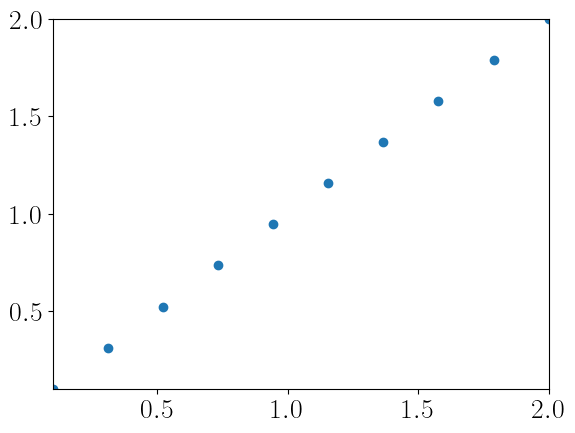

In [231]:
n_inp = 8
a = 0.1
b = 2
T = 10
V = 21

labels_train = linspace(a, b, T)
# labels_train = np.sort(uniform(a, b, T))
svs_train = []
for p in labels_train:
    ham = ham_func(n_inp, p, *ham_args)
    svs_train.append(eigh(ham)[1][:,0])

labels_test = linspace(a, b, V)
svs_test = []
for p in labels_test:
    ham = ham_func(n_inp, p, *ham_args)
    svs_test.append(eigh(ham)[1][:,0])

plt.scatter(labels_train, labels_train)
plt.xlim(a, b)
plt.ylim(a, b)

In [ ]:
n_meas_list = [0, 4]
n_copies = 1
n_tot = n_inp*n_copies

w_ls = 1e0
w_var = 1e-4

dp = 1e-5

# x0 = concatenate([normal(pi/2, 0.1, 3*n_inp*n_copies*n_layers), normal(0., 1, 2**n_meas)])
# x0 = concatenate([uniform(0, 2*pi, 3*n_inp*n_copies*n_layers), normal(0., 1, 2**n_meas)])
# x0 = array(pars)
x0 = None

time_start = time()
fvals, result, CFIs, QFIs = train_qcnn_cfi(ham_func, labels_train, ham_args, n_inp, n_meas_list=n_meas_list, n_copies=n_copies, method="BFGS", x0=x0, fvals=[])
time_finish = time() - time_start
print("\nFinished in", time_finish)
print("Cost:", result.fun)
print(result.message)
pars = result.x

			Iteration: 906 | Cost: 0.54829254 | Time passed: 28196 s

In [ ]:
def two_qubit_ising_qfi(h):
    return 4/(1 + 4*h**2)**2

def ising_qfi(n_inp, h, J=1):
    res = 0
    for k in range(1, int(n_inp/2) + 1):
        ck = cos(2*pi*k/n_inp)
        res += J**2*(1 - ck**2)/(J**2 + h**2 - 2*J*h*ck)**2
    return res

def ising_qfi_other(n_inp, h, J=1):
    res = 0
    for k in range(1, int(n_inp/2) + 1):
        res += (J*sin(k))**2/(J**2 + h**2 - 2*J*h*cos(k))**2
    return res

In [ ]:
print("QCNN")
print("n=%d | m=%s | w_var=%f \n" %(n_inp, n_meas_list, w_var))
print("MSE:           ", sum((CFIs - QFIs)**2)/T)

plt.figure(figsize=(6, 4))
plt.plot(np.sort(labels_train), 1/QFIs, color="C2", label=r"$\frac{1}{I_q}$", linewidth=8, linestyle="solid") # , color="tab:blue"
plt.plot(np.sort(labels_train), 1/CFIs, label=r"$\frac{1}{I_c}$", linewidth=1.5, linestyle="dashed") # , color="tab:red"
# plt.plot(np.sort(labels_train), [1/two_qubit_ising_qfi(h) for h in labels_train], label=r"QFI analytical", linewidth=1.5, linestyle="solid") # , color="tab:red"
# plt.plot(np.sort(labels_train), [1/ising_qfi(n_inp, h) for h in labels_train], label=r"QFI analytical", linewidth=1.5, linestyle="solid") # , color="tab:red"
# plt.plot(np.sort(labels_train), [1/ising_qfi_other(n_inp, h) for h in labels_train], label=r"QFI other analytical", linewidth=1.5, linestyle="solid") # , color="tab:red"
plt.ylabel(r"$\frac{\Delta^2 H}{|\partial_\alpha \langle H \rangle |^2}$" )
plt.xlabel(r"$\alpha$")
plt.grid()
# plt.yscale("log")
plt.legend()
# plt.savefig(save_path + file_info + postfix + "-var.pdf", transparent=True, bbox_inches='tight')
plt.show()

QCNN
n=8 | m=[0] | w_var=0.000100 

MSE:            0.42288002153063387


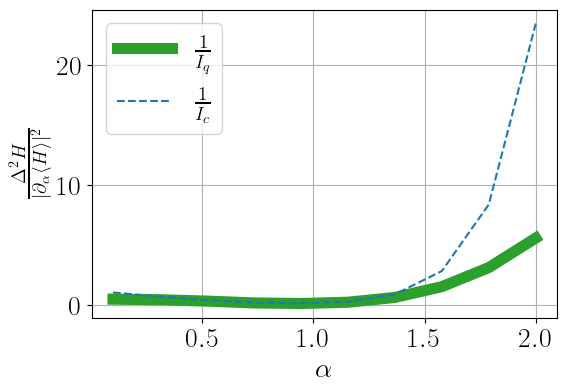

QCNN
n=4 | m=[0, 2] | w_var=0.000100 

MSE:            7.2245228657989014e-06


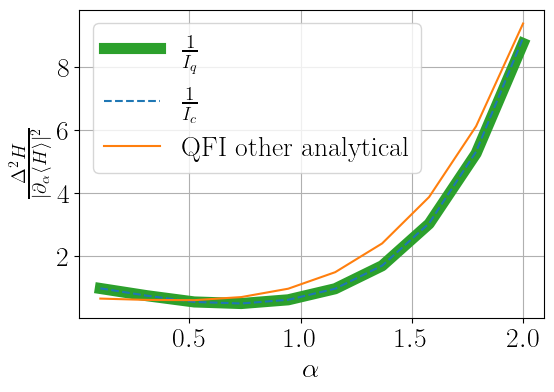

QCNN
n=4 | m=[0] | w_var=0.000100 

MSE:            0.0012439881661512682


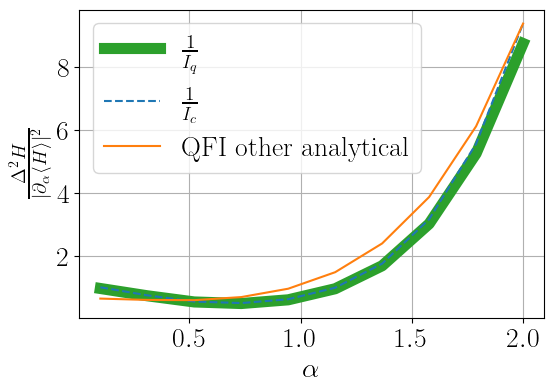

In [155]:
CFIs_train, QFIs_train = aux_info_qcnn_cfi(ham_func, labels_train, ham_args, n_inp, pars, n_meas_list=n_meas_list, n_copies=n_copies, dp=dp)
CFIs_test, QFIs_test = aux_info_qcnn_cfi(ham_func, labels_test, ham_args, n_inp, pars, n_meas_list=n_meas_list, n_copies=n_copies, dp=dp)

QCNN
n=2 | m=[0] | w_var=0.000100 

Cost:           3.904218806607146e-09
MSE:            6.377056669708659e-09
MSE:            3.904196899741489e-09


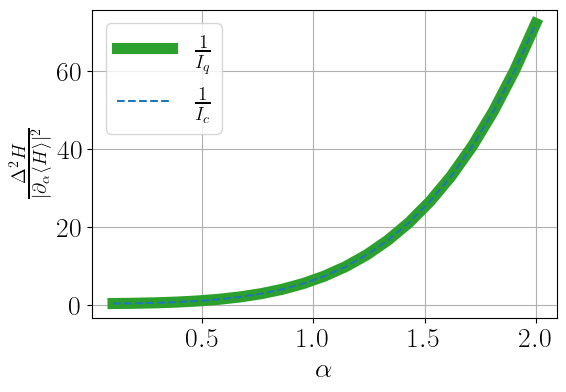

In [156]:
print("QCNN")
print("n=%d | m=%s | w_var=%f \n" %(n_inp, n_meas_list, w_var))
print("Cost:          ", result.fun)
print("MSE:           ", sum((CFIs_test - QFIs_test)**2)/1)
print("MSE:           ", sum((CFIs_train - QFIs_train)**2)/1)

plt.figure(figsize=(6, 4))
plt.plot(np.sort(labels_test), 1/QFIs_test, color="C2", label=r"$\frac{1}{I_q}$", linewidth=8, linestyle="solid") # , color="tab:blue"
plt.plot(np.sort(labels_test), 1/CFIs_test, label=r"$\frac{1}{I_c}$", linewidth=1.5, linestyle="dashed") # , color="tab:red"
plt.ylabel(r"$\frac{\Delta^2 H}{|\partial_\alpha \langle H \rangle |^2}$" )
plt.xlabel(r"$\alpha$")
plt.grid()
# plt.yscale("log")
plt.legend()
# plt.savefig(save_path + file_info + postfix + "-var.pdf", transparent=True, bbox_inches='tight')
plt.show()

In [ ]:
save_path = r"/home/kardashin/Work/QCNN-var/Results/Schwinger/"
file_info = r"schwinger-n=%d-c=%d-m=%s-w_ls=%.1f-w_var=%.4f" %(n_inp, n_copies, n_meas_list, w_ls, w_var)
postfix = "-4"
save_path + file_info + postfix

In [ ]:
np.save(save_path + file_info + postfix + "-labels_train", labels_train, allow_pickle=True)

data_dict = {
    "n": n_inp,
    "c": n_copies,
    "a": a,
    "b": b,
    "w_ls": w_ls, 
    "w_var": w_var, 
    "labels_train": labels_train,
    "fvals": array(fvals),
    "nit": result.nit,
    "nfev": result.nfev,
    "xf": result.x,
    "time": time_finish,
    "note": "Schwinger Hamiltonian, w=g=1. Ansatz: QCNN from https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.5.043250.",
} 

with open(save_path + file_info + postfix + ".out", 'wb') as fp:
    pickle.dump(data_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

QCNN
n=4 | m=[0] | w_var=0.000100 

Cost:           0.03801203696304742
MSE:            0.001131202148364724
Total variance: 128.00054629369578


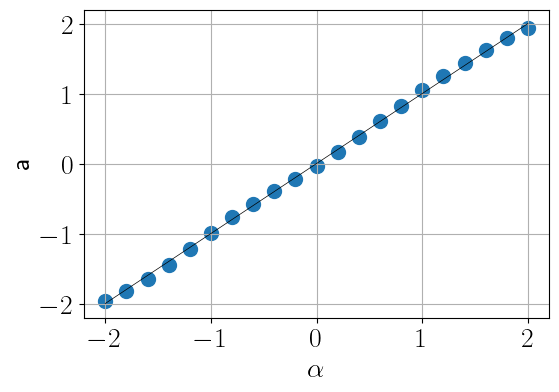

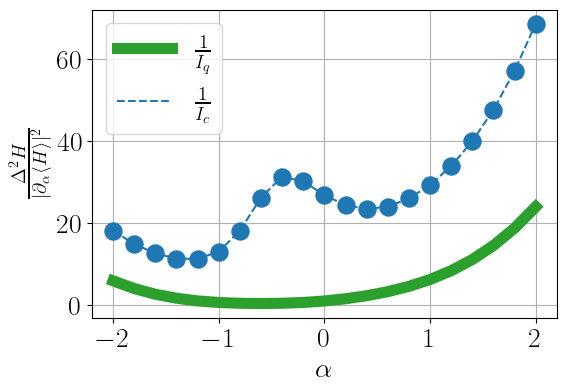

QCNN
n=4 | m=[0, 2] | w_var=0.000100 

Cost:           0.010564993806693674
MSE:            0.00019898412163496895
Total variance: 40.35061242778694


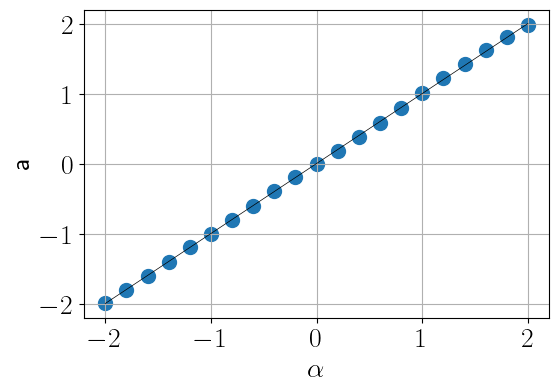

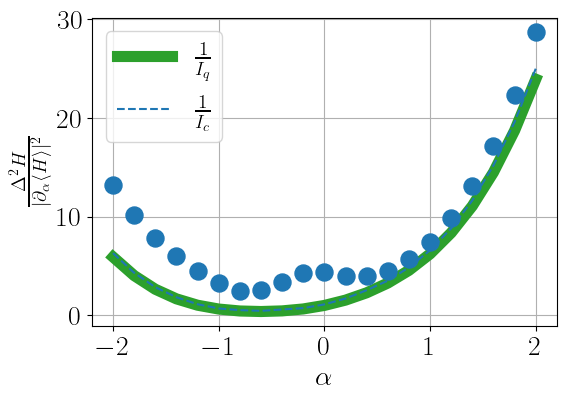

QCNN
n=4 | m=[0, 1, 2, 3] | w_var=0.000100 

Cost:           0.010188755019742826
MSE:            0.00017702928173393925
Total variance: 39.60547151920454


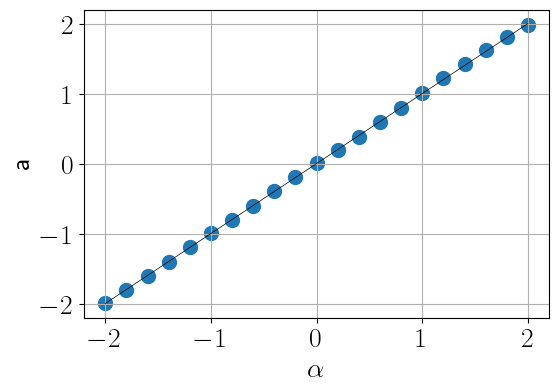

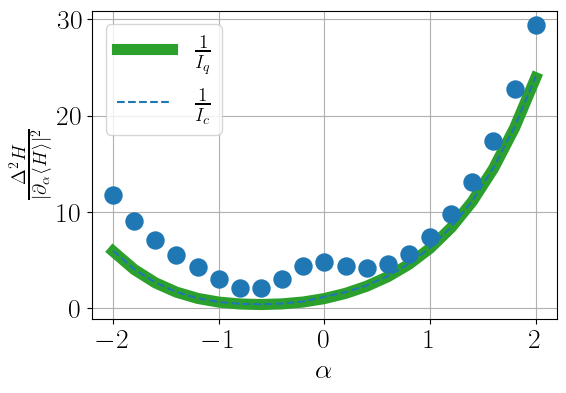

In [15]:
n_inp = 8
a = -2
b = 2
T = 10
V = 21

n_meas = 1
n_copies = 1
n_tot = n_inp*n_copies

w_ls = 1e0
w_var = 1e-4

dp = 1e-5

save_path = r"/home/kardashin/Work/QCNN-var/Results/Schwinger/"
file_info = r"schwinger-n=%d-c=%d-m=%d-w_ls=%.1f-w_var=%.4f" %(n_inp, n_copies, n_meas, w_ls, w_var)
save_path + file_info

'/home/kardashin/Work/QCNN-var/Results/Schwinger/schwinger-n=8-c=1-m=1-w_ls=1.0-w_var=0.0001'

In [16]:
with open(save_path + file_info + ".out", 'rb') as fp:
    data_dict_loaded = pickle.load(fp)
data_dict_loaded

{'n': 8,
 'c': 1,
 'a': -2,
 'b': 2,
 'w_ls': 1.0,
 'w_var': 0.0001,
 'labels_train': array([-1.89459004, -1.75537775, -1.33288886, -0.85739768, -0.51158038,
        -0.00701667,  0.09074402,  1.03094086,  1.64553511,  1.95182399]),
 'fvals': array([1.72397510e+01, 1.69260050e+01, 1.51603117e+01, ...,
        1.32572683e-02, 1.32572682e-02, 1.32572682e-02]),
 'nit': 11833,
 'nfev': 2603160,
 'xf': array([-1.57077538e+00,  1.84456695e+00, -2.13143924e+00,  7.85354938e-01,
        -1.56964327e+00,  2.20066488e+00,  1.40719140e+00, -4.19963936e-06,
         7.85385408e-01, -1.40376582e+00,  6.91200453e-01,  2.48499070e+00,
         8.64983666e-01,  1.37694040e+00,  1.42364246e+00,  7.85187207e-01,
         3.13825395e+00,  6.28677538e-01,  7.85440130e-01, -1.22588060e-03,
         2.75884503e-01,  1.58441681e+00, -3.80532600e-02,  7.52752298e-01,
        -1.06151007e+00, -9.74724891e-01,  1.05852205e+00,  1.54709437e+00,
         1.23981298e+00, -1.09290237e+00,  2.59534358e-03,  2.570335

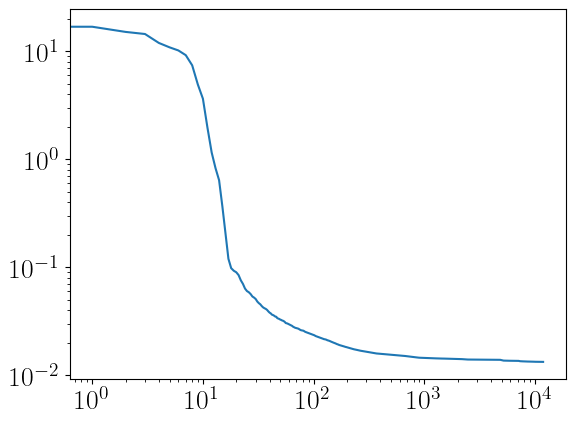

In [24]:
plt.plot(data_dict_loaded["fvals"])
plt.xscale("log")
plt.yscale("log")

# HEA

In [5]:
def xz_rot(pars):
    """ xz-rotation """
    e1 = exp(1j*pars[1])
    e1c0 = e1*cos(pars[0])
    e1s0 = e1*sin(pars[0])
    return np.array([[e1c0.conjugate(), -1j*e1s0.conjugate()],
                     [        -1j*e1s0,                 e1c0]])

def rxx(N, q1, q2, par):
    d = 2**N
    j, k = sorted([q1, q2])
    term_1 = diag(full(d, cos(par)))
    term_21 = kron_N_A(X, 2**j) # I^(j-1) X
    term_21 = kron_A_N(term_21, 2**(k - j - 1)) # I^(j-1) X I^(k-j-2)
    term_22 = kron_A_N(X, 2**(N - k - 1)) # X I^(n-k)
    term_2 = fkron(term_21, term_22) # I^(j-1) X I^(k-j-1) X I^(n-k)
    term_2 = -1j*sin(par)*term_2
    return term_1 + term_2

def hea_rxx(N, L, pars):
    it = iter(pars)
    op = eye(2**N)
    for l in range(L):
        op_s = xz_rot([next(it), next(it)])
        for q in range(N - 1):
            op_s = fkron(op_s, xz_rot([next(it), next(it)]))
        op = op_s@op
        for q in range(N - 1):
            op = rxx(N, q, q + 1, next(it))@op
        if N > 2:
            op = rxx(N, 0, N - 1, next(it))@op
    return op

In [6]:
def train_pure(svs, labels, n_layers, n_copies=1, n_meas=0, method="BFGS", w_ls=1e0, w_var=1e-4, x0=None, options={}, save_data=False, file_name=None, fvals=[]):

    n_inp = int(log2(len(svs[0])))
    n_tot = n_inp*n_copies
    d = 2**n_tot
    if n_meas == 0:
        n_meas = n_tot
    d_diff = 2**(n_tot - n_meas)
    
    n_pars_est = 2**n_meas
    n_pars_ans = 3*n_inp*n_copies*n_layers
    
    svs_cop = []
    for sv in svs:
        svs_cop.append(reduce(kron, [sv]*n_copies))

    fval_cont = [0]
    def fun(x):
        x_ans, x_est = x[:n_pars_ans], x[n_pars_ans:]
        U = hea_rxx(n_tot, n_layers, x_ans)
        H_u = (U.conj().T*kron_A_I_diag(x_est, d_diff))@U
        expecs = []
        disps = []
        for j in range(len(labels)):
            H_u_v0 = H_u@svs_cop[j]
            expecs.append((svs_cop[j].conj().T@H_u_v0).real)
            disps.append((H_u_v0.conj().T@H_u_v0).real)
        f = w_ls*np.sum((array(expecs) - array(labels))**2)
        f += w_var*np.sum(array(disps) - array(expecs)**2)
        fval_cont[0] = f
        return f    

    if save_data == True and file_name is None:
        file_name = "pars-c=%d-m=%d=l=%d-w_ls=%f-w_var=%f-n_train=%d" %(n_copies, n_meas, n_layers, w_ls, w_var, len(labels))
    
    time_loc = time()
    
    def callback(x):
        fvals.append(fval_cont[0])
        print("\t\t\tIteration: %d | Cost: %.8f | Time passed: %d s" %(len(fvals), fval_cont[0], time() - time_loc), end="\r")
        if save_data == True:
            np.save(file_name, x)
        return None
    
    if method in ["Nelder-Mead", "L-BFGS-B", "SLSQP", "TNC", "Powell", "COBYLA"]:
        bounds = [(0, 2*pi)]*n_pars_ans + [(None, None)]*n_pars_est
    else:
        bounds = None
    if x0 is None:
        x0_ans = normal(pi/4, 0.1*pi, n_pars_ans)
        x0_est = normal(0, 1, n_pars_est)
        x0 = concatenate([x0_ans, x0_est])
    
    optimization_result = minimize(fun=fun, x0=x0, callback=callback, bounds=bounds, method=method, options=options)

    return fvals, optimization_result

In [7]:
def train_pure_naimark(svs, labels, n_layers, n_copies=1, n_ext=1, method="BFGS", w_ls=1e0, w_var=1e-4, x0=None, options={}, save_data=False, file_name=None):

    n_inp = int(log2(len(svs[0])))
    n_tot = n_inp*n_copies + n_ext
    d_prim =  2**(n_inp*n_copies)

    n_pars_est = 2**n_ext
    n_pars_ans = 3*n_tot*n_layers
    
    svs_cop = []
    for sv in svs:
        svs_cop.append(reduce(kron, [sv]*n_copies + [array([1, 0])]*n_ext))

    fvals = []
    fval_cont = [0]
    def fun(x):
        x_ans, x_est = x[:n_pars_ans], x[n_pars_ans:]
        U = hea_rxx(n_tot, n_layers, x_ans)
        H_u = (U.conj().T*kron_I_A_diag(x_est, d_prim))@U
        # H_u = (ansatz.conj().T*x_est)@ansatz
        expecs = []
        disps = []
        for j in range(len(labels)):
            H_u_v0 = H_u@svs_cop[j]
            expecs.append((svs_cop[j].conj().T@H_u_v0).real)
            disps.append((H_u_v0.conj().T@H_u_v0).real)
        f = w_ls*np.sum((array(expecs) - array(labels))**2)
        f += w_var*np.sum(array(disps) - array(expecs)**2)
        fval_cont[0] = f
        return f    

    if file_name is None:
        file_name = "pars-c=%d-e=%d=l=%d-w_ls=%f-w_var=%f-n_train=%d" %(n_copies, n_ext, n_layers, w_ls, w_var, len(labels))
    
    time_loc = time()
    
    def callback(x):
        fvals.append(fval_cont[0])
        print("\t\t\tIteration: %d | Cost: %.8f | Time passed: %d s" %(len(fvals), fval_cont[0], time() - time_loc), end="\r")
        if save_data == True:
            np.save(file_name, x)
        return None
    
    if method in ["Nelder-Mead", "L-BFGS-B", "SLSQP", "TNC", "Powell", "COBYLA"]:
        bounds = [(0, 2*pi)]*n_pars_ans + [(None, None)]*n_pars_est
    else:
        bounds = None
    if x0 is None:
        x0_ans = normal(pi/4, 0.1*pi, n_pars_ans)
        x0_est = normal(0, 1, n_pars_est)
        x0 = concatenate([x0_ans, x0_est])
    
    optimization_result = minimize(fun=fun, x0=x0, callback=callback, bounds=bounds, method=method, options=options)

    return fvals, optimization_result

In [8]:
def aux_info(ham_func, ham_pars, ham_args, n_inp, n_layers, pars, n_copies=1, n_meas=0, dp=1e-5):
    """ For the optimized variables theta and x,
    calculates the expectations expecs, their derivatives excepcs_der,
    their variances disps, and quantum and classical Fisher informations """

    n_tot = n_inp*n_copies
    d = 2**n_tot
    
    if n_meas == 0:
        n_meas = n_tot
    
    pars_ans = pars[:-2**n_meas]
    pars_est = pars[-2**n_meas:]

    ansatz = hea_rxx(n_tot, n_layers, pars_ans)
    projs = [reduce(kron, [diag(line), eye(2**(n_tot - n_meas))]) for line in eye(2**n_meas)]
    projs_u = [ansatz.conj().T@proj@ansatz for proj in projs]
   
    v0s = []
    v0s_der = []
    QFIs = []
    for p in ham_pars:        
        ham = ham_func(n_inp, p, *ham_args)
        ham_p = ham_func(n_inp, p+dp, *ham_args)
        ham_m = ham_func(n_inp, p-dp, *ham_args)
        ham_der = (ham_p - ham_m)/(2*dp)

        evals_ham, evecs_ham = eigh(ham)
        e0 = evals_ham[0]
        v0 = evecs_ham[:,0]
        e0_der = (v0.conj().T@ham_der@v0).real # Hellmann-Feynman theorem
        
        mat = ham - e0*eye(2**n_inp)
        mat_der = ham_der - e0_der*eye(2**n_inp) # in literature, the second term is absent for some reason
        
        v0_der = -pinv(mat, rcond=1e-12, hermitian=True)@mat_der@v0 # rcond is important! does not work with the default value
        # v0_der = sum([evecs_ham[:,i].conj().T@ham_der@v0/(evals_ham[i] - e0)*evecs_ham[:,i] for i in range(1, 2**n_inp) if evals_ham[i] - e0 != 0]) # other method, memory-inefficient
        
        ### checks; should be zeros ###
        # print(norm(mat_der@v0 + mat@v0_der))
        # print(norm((ham_der@v0 + ham@v0_der) - (e0_der*v0 + e0*v0_der)))
        # print()
    
        v0_der = sum([reduce(kron, [v0]*c + [v0_der] + [v0]*(n_copies - c - 1)) for c in range(n_copies)]) # memory-inefficient, but is a fancy one-liner
        v0 = reduce(kron, [v0]*n_copies)

        QFI = 4*(vdot(v0_der, v0_der) - vdot(v0_der, v0)*vdot(v0, v0_der)).real + 1e-10

        v0s.append(v0)
        v0s_der.append(v0_der)
        QFIs.append(QFI)  

    expecs = []
    expecs_der = []
    disps = []
    CFIs = []
    for j in range(len(ham_pars)): # take a density matrix from the training set
        probs = [(v0s[j].conj().T@proj@v0s[j]).real for proj in projs_u]
        probs_der = [2*(v0s_der[j].conj().T@proj@v0s[j]).real for proj in projs_u]
        
        expec = sum([ev*prob for ev, prob in zip(pars_est, probs)])
        expec_der = sum([ev*prob_der for ev, prob_der in zip(pars_est, probs_der)])
        disp = sum([ev**2*prob for ev, prob in zip(pars_est, probs)]) - expec**2
        
        CFI = sum([prob_der**2/prob if prob > 0 else 0 for prob_der, prob in zip(probs_der, probs)]) + 1e-10
        
        expecs.append(expec)
        expecs_der.append(expec_der)
        disps.append(disp)
        CFIs.append(CFI)
    
    return array(expecs), array(expecs_der), array(disps), array(CFIs), array(QFIs)

In [9]:
def aux_info_naimark(ham_func, ham_pars, ham_args, n_inp, n_layers, pars, n_copies=1, n_ext=1, dp=1e-5):
    """ For the optimized variables theta and x,
    calculates the expectations expecs, their derivatives excepcs_der,
    their variances disps, and quantum and classical Fisher informations """

    n_tot = n_inp*n_copies + n_ext
    d_prim =  2**(n_inp*n_copies)

    s0 = array([1, 0])
    
    pars_ans = pars[:-2**n_ext]
    pars_est = pars[-2**n_ext:]

    ansatz = hea_rxx(n_tot, n_layers, pars_ans)
    projs = [reduce(kron, [eye(d_prim), diag(line)]) for line in eye(2**n_ext)]
    projs_u = [ansatz.conj().T@proj@ansatz for proj in projs]
   
    v0s = []
    v0s_der = []
    QFIs = []
    for p in ham_pars:        
        ham = ham_func(n_inp, p, *ham_args)
        ham_p = ham_func(n_inp, p+dp, *ham_args)
        ham_m = ham_func(n_inp, p-dp, *ham_args)
        ham_der = (ham_p - ham_m)/(2*dp)

        evals_ham, evecs_ham = eigh(ham)
        e0 = evals_ham[0]
        v0 = evecs_ham[:,0]
        e0_der = (v0.conj().T@ham_der@v0).real # Hellmann-Feynman theorem
        
        mat = ham - e0*eye(2**n_inp)
        mat_der = ham_der - e0_der*eye(2**n_inp) # in literature, the second term is absent for some reason
        
        v0_der = -pinv(mat, rcond=1e-12, hermitian=True)@mat_der@v0 # rcond is important! does not work with the default value
        # v0_der = sum([evecs_ham[:,i].conj().T@ham_der@v0/(evals_ham[i] - e0)*evecs_ham[:,i] for i in range(1, 2**n_inp) if evals_ham[i] - e0 != 0]) # other method, memory-inefficient
        
        ### checks; should be zeros ###
        # print(norm(mat_der@v0 + mat@v0_der))
        # print(norm((ham_der@v0 + ham@v0_der) - (e0_der*v0 + e0*v0_der)))
        # print()
    
        v0_der = sum([reduce(kron, [v0]*c + [v0_der] + [v0]*(n_copies - c - 1) + [s0]*n_ext) for c in range(n_copies)]) # memory-inefficient, but is a fancy one-liner
        v0 = reduce(kron, [v0]*n_copies + [s0]*n_ext)

        QFI = 4*(vdot(v0_der, v0_der) - vdot(v0_der, v0)*vdot(v0, v0_der)).real + 1e-10

        v0s.append(v0)
        v0s_der.append(v0_der)
        QFIs.append(QFI)  

    expecs = []
    expecs_der = []
    disps = []
    CFIs = []
    for j in range(len(ham_pars)): # take a density matrix from the training set
        probs = [(v0s[j].conj().T@proj@v0s[j]).real for proj in projs_u]
        probs_der = [2*(v0s_der[j].conj().T@proj@v0s[j]).real for proj in projs_u]
        
        expec = sum([ev*prob for ev, prob in zip(pars_est, probs)])
        expec_der = sum([ev*prob_der for ev, prob_der in zip(pars_est, probs_der)])
        disp = sum([ev**2*prob for ev, prob in zip(pars_est, probs)]) - expec**2
        
        CFI = sum([prob_der**2/prob if prob > 0 else 0 for prob_der, prob in zip(probs_der, probs)]) + 1e-10
        
        expecs.append(expec)
        expecs_der.append(expec_der)
        disps.append(disp)
        CFIs.append(CFI)
    
    return array(expecs), array(expecs_der), array(disps), array(CFIs), array(QFIs)

### Settings

In [10]:
# ham_func = ising_ham
ham_func = schwinger_ham

ham_args = []

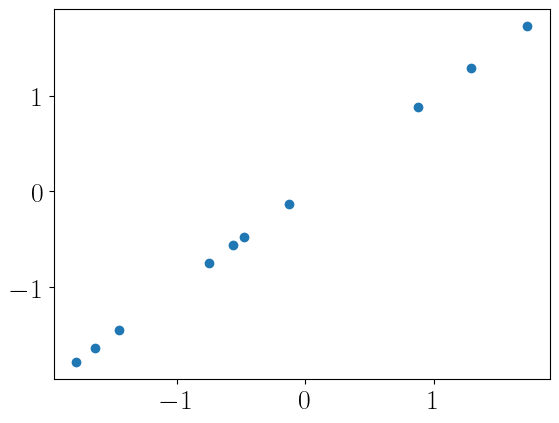

In [16]:
n_inp = 4
a = -2
b = 2
T = 10
V = 20

# labels_train = linspace(a, b, T)
labels_train = np.sort(uniform(a, b, T))
svs_train = []
for p in labels_train:
    ham = ham_func(n_inp, p, *ham_args)
    svs_train.append(eigh(ham)[1][:,0])

labels_test = linspace(a, b, V)
svs_test = []
for p in labels_test:
    ham = ham_func(n_inp, p, *ham_args)
    svs_test.append(eigh(ham)[1][:,0])

plt.scatter(labels_train, labels_train)

### Vanila

In [17]:
n_copies = 1
n_meas = n_inp*n_copies
n_tot = n_inp*n_copies
n_layers = 2

w_ls = 1e0
w_var = 1e-4

dp = 1e-5

# x0 = concatenate([normal(pi/2, 0.1, 3*n_inp*n_copies*n_layers), normal(0., 1, 2**n_meas)])
x0 = concatenate([uniform(0, 2*pi, 3*n_inp*n_copies*n_layers), normal(0., 1, 2**n_meas)])
# x0 = array(pars)

save_path = r"/home/kardashin/Work/QPE/Results/Ising/"
file_info = r"Ising-pars-c=%d-m=%d-l=%d-w_ls=%f-w_var=%f" %(n_copies, n_meas, n_layers, w_ls, w_var)
# x0 = np.load(save_path + file_info + r"-w_var=%f.npy" %(w_var))

time_start = time()
fvals, result = train_pure(svs_train, labels_train, n_layers, n_copies=n_copies, n_meas=n_meas, method="BFGS", 
                           w_ls=w_ls, w_var=w_var, x0=x0, save_data=False, fvals=[])
time_finish = time() - time_start
print("\nFinished in", time_finish)
print("Cost:", result.fun)
print(result.message)
pars = result.x

			Iteration: 1507 | Cost: 0.00865102 | Time passed: 28 s
Finished in 28.997727632522583
Cost: 0.008651019307660516
Optimization terminated successfully.


In [18]:
expecs_train, expecs_der_train, disps_train, CFIs_train, QFIs_train = aux_info(ham_func, labels_train, ham_args, n_inp, n_layers, pars, n_copies=n_copies, n_meas=n_meas, dp=dp)
expecs_test, expecs_der_test, disps_test, CFIs_test, QFIs_test = aux_info(ham_func, labels_test, ham_args, n_inp, n_layers, pars, n_copies=n_copies, n_meas=n_meas, dp=dp)
biass_train = expecs_train - labels_train
biass_test = expecs_test - labels_test

Vanila
n=4 | m=4 | l=2 | w_var=0.000100
Cost:           0.008651019307660516
MSE:            0.0013280023495414845
Total variance: 28.17786031736486


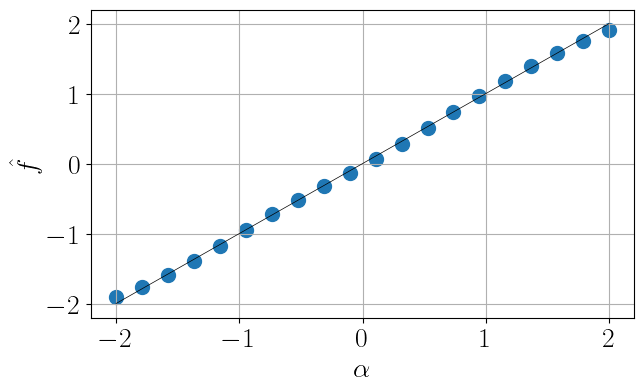

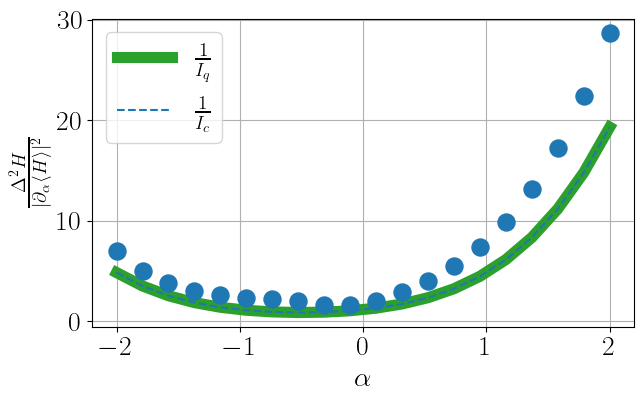

In [19]:
print("Vanila")
print("n=%d | m=%d | l=%d | w_var=%f" %(n_inp, n_meas, n_layers, w_var))
print("Cost:          ", result.fun)
print("MSE:           ", sum((expecs_test - labels_test)**2)/V)
print("Total variance:", sum(disps_test)/(b - a))

plt.figure(figsize=(7, 4))
plt.scatter(labels_test, expecs_test, s=100)
plt.plot(labels_test, labels_test, color="black", linewidth=0.5)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\hat{f}$")
# plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(7, 4))
plt.scatter(labels_test, disps_test/expecs_der_test**2, s=150, zorder=10)
plt.plot(np.sort(labels_test), 1/QFIs_test, color="C2", label=r"$\frac{1}{I_q}$", linewidth=8, linestyle="solid") # , color="tab:blue"
plt.plot(np.sort(labels_test), 1/CFIs_test, label=r"$\frac{1}{I_c}$", linewidth=1.5, linestyle="dashed") # , color="tab:red"
plt.ylabel(r"$\frac{\Delta^2 H}{|\partial_\alpha \langle H \rangle |^2}$" )
plt.xlabel(r"$\alpha$")
plt.grid()
# plt.yscale("log")
plt.legend()
plt.show()

Vanila
n=4 | m=1 | l=7 | w_var=0.000100
Cost:           0.032630640012227104
MSE:            0.0008746216482717736
Total variance: 111.02933726108392


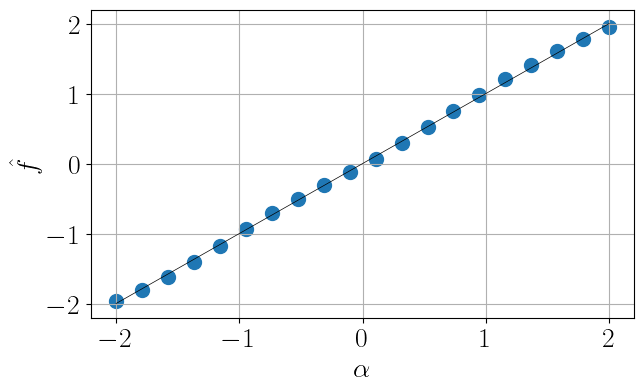

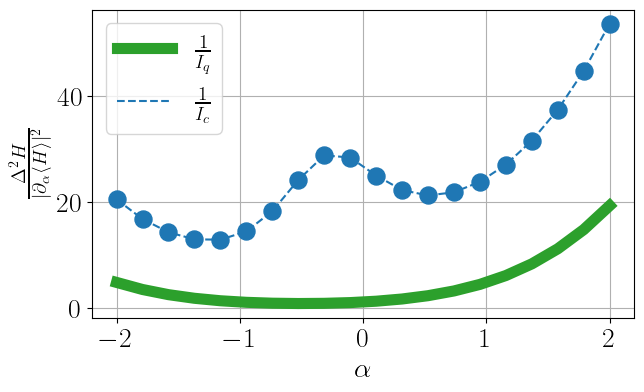

Vanila
n=4 | m=4 | l=2 | w_var=0.000100
Cost:           0.01679941711374276
MSE:            0.0008971328292601551
Total variance: 32.170119143737566


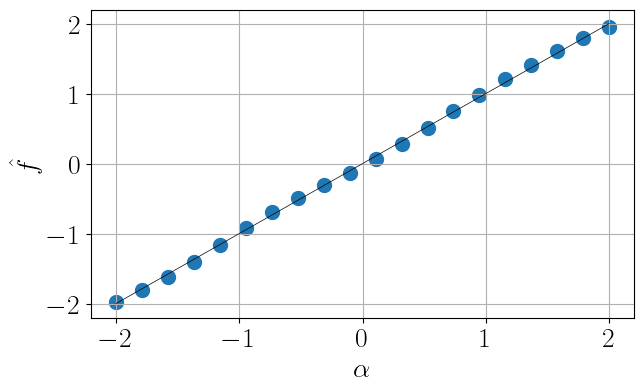

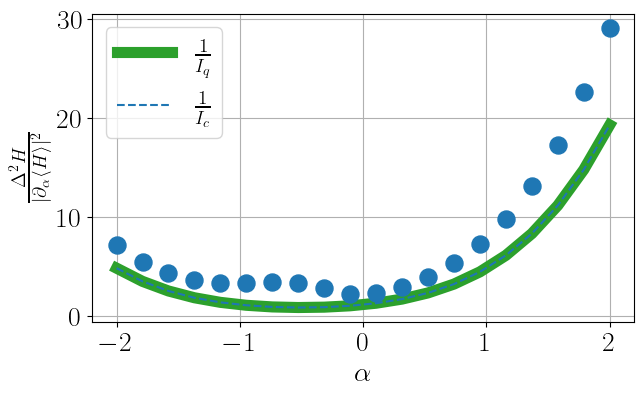

QCNN
n=4 | w_var=0.000100 

Cost:           0.03299059059745354
MSE:            0.000873649186433771
Total variance: 112.87076246932557


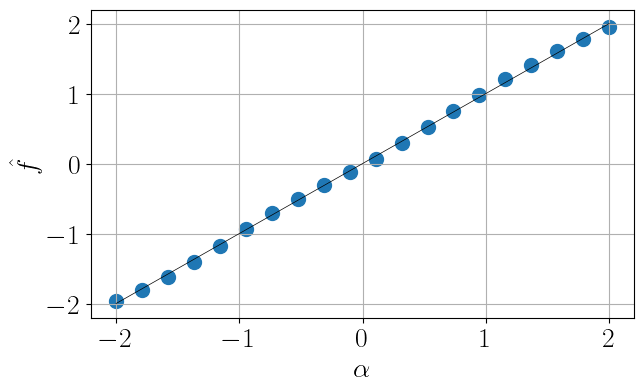

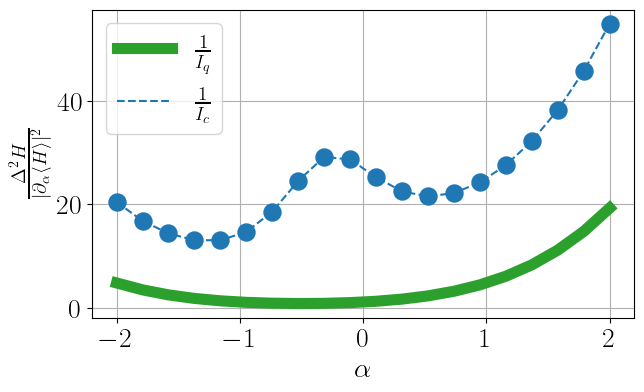

n=8 | m=2 | l=5 | w_var=0.000100 

Cost:           0.007126811907287418
MSE:            9.857934224249691e-05
Total variance: 28.52497969193122


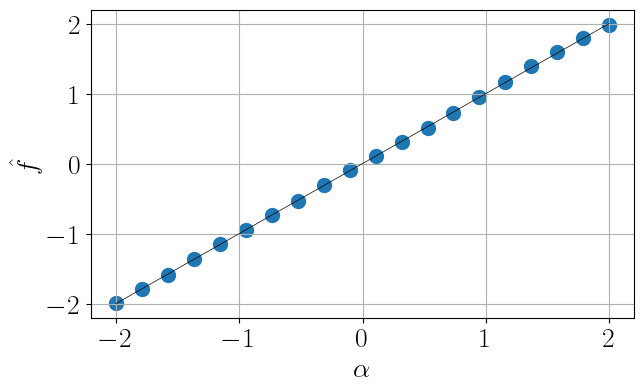

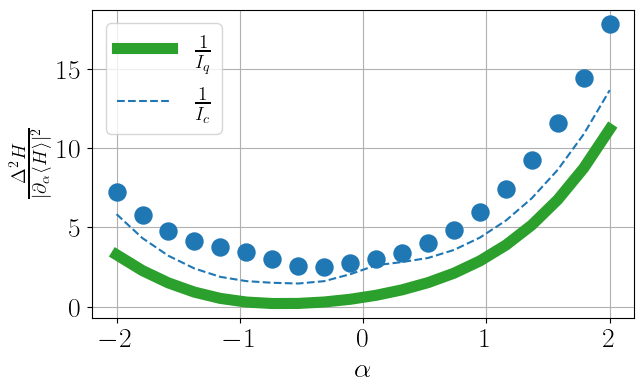

n=8 | m=2 | l=5 | w_var=0.000100 

Cost:           0.007126811907287418
MSE:            9.857934224249691e-05
Total variance: 28.52497969193122


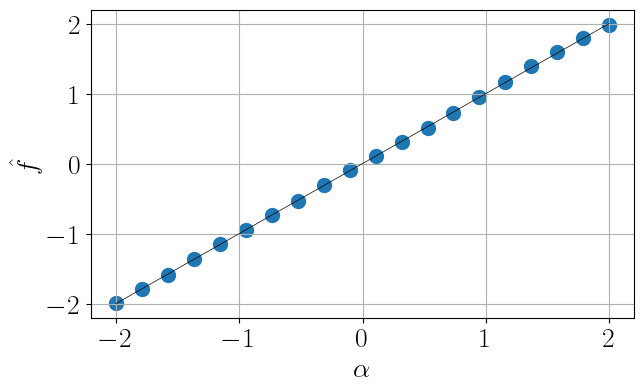

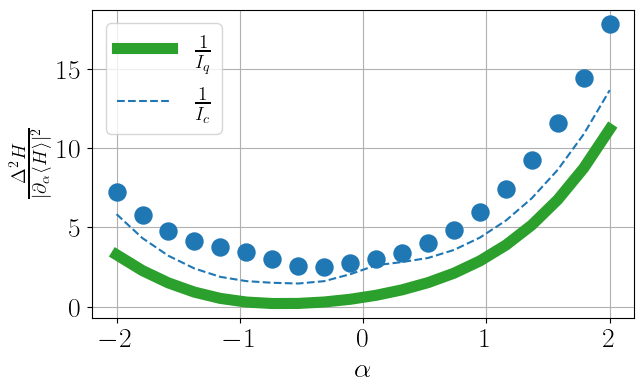

### Naimark

In [50]:
n_copies = 1
n_ext = 2
n_tot = n_inp*n_copies + n_ext
n_layers = 7

w_ls = 1e0
w_var = 1e-4

dp = 1e-5

# x0 = concatenate([normal(pi/2, 0.1, 3*n_inp*n_copies*n_layers), normal(0., 1, 2**n_meas)])
x0 = concatenate([uniform(0, 2*pi, 3*n_tot*n_layers), normal(0., 1, 2**n_ext)])
# x0 = array(pars)

save_path = r"/home/kardashin/Work/QPE/Results/Ising/"
file_info = r"Ising-pars-c=%d-e=%d-l=%d-w_ls=%f" %(n_copies, n_ext, n_layers, w_ls)

time_start = time()
fvals, result = train_pure_naimark(svs_train, labels_train, n_layers, n_copies=n_copies, n_ext=n_ext, method="BFGS", 
                                   w_ls=w_ls, w_var=w_var, x0=x0, save_data=False)
time_finish = time() - time_start
print("\nFinished in", time_finish)
print("Cost:", result.fun)
print(result.message)
pars = result.x

			Iteration: 8923 | Cost: 0.01612090 | Time passed: 8497 s
Finished in 8519.965662002563
Cost: 0.01612090023157927
Desired error not necessarily achieved due to precision loss.


In [51]:
expecs_train, expecs_der_train, disps_train, CFIs_train, QFIs_train = aux_info_naimark(ham_func, labels_train, ham_args, n_inp, n_layers, pars, n_copies=n_copies, n_ext=n_ext, dp=dp)
expecs_test, expecs_der_test, disps_test, CFIs_test, QFIs_test = aux_info_naimark(ham_func, labels_test, ham_args, n_inp, n_layers, pars, n_copies=n_copies, n_ext=n_ext, dp=dp)
biass_train = expecs_train - labels_train
biass_test = expecs_test - labels_test

n=4 | e=2 | l=7 | w_var=0.000100 

Cost:           0.01612090023157927
MSE:            0.0008533474239746635
Total variance: 31.289614513449216


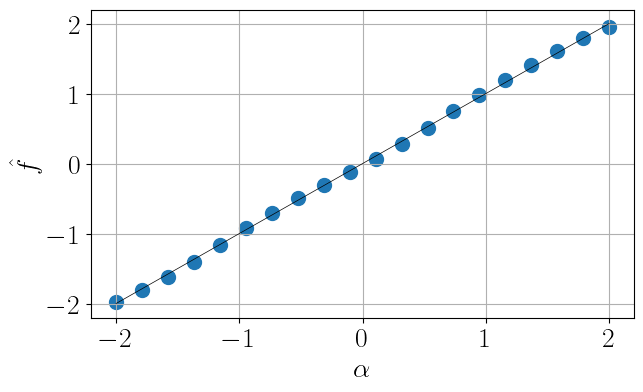

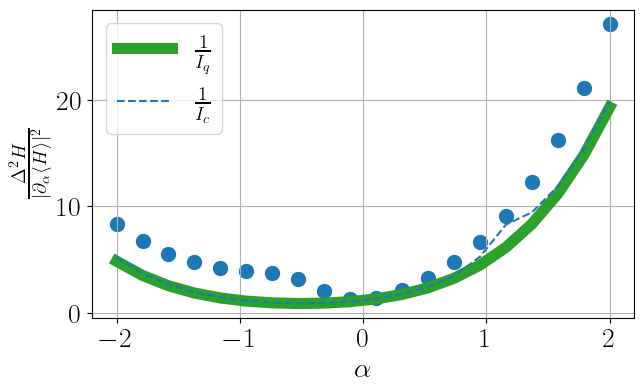

In [52]:
print("n=%d | e=%d | l=%d | w_var=%f \n" %(n_inp, n_ext, n_layers, w_var))
print("Cost:          ", result.fun)
print("MSE:           ", sum((expecs_test - labels_test)**2)/V)
print("Total variance:", sum(disps_test)/(b - a))

plt.figure(figsize=(7, 4))
plt.scatter(labels_test, expecs_test, s=100)
plt.plot(labels_test, labels_test, color="black", linewidth=0.5)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\hat{f}$")
# plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(7, 4))
plt.scatter(labels_test, disps_test/expecs_der_test**2, s=100)
plt.plot(np.sort(labels_test), 1/QFIs_test, color="C2", label=r"$\frac{1}{I_q}$", linewidth=8, linestyle="solid") # , color="tab:blue"
plt.plot(np.sort(labels_test), 1/CFIs_test, label=r"$\frac{1}{I_c}$", linewidth=1.5, linestyle="dashed") # , color="tab:red"
plt.ylabel(r"$\frac{\Delta^2 H}{|\partial_\alpha \langle H \rangle |^2}$" )
plt.xlabel(r"$\alpha$")
plt.grid()
# plt.yscale("log")
plt.legend()
plt.show()

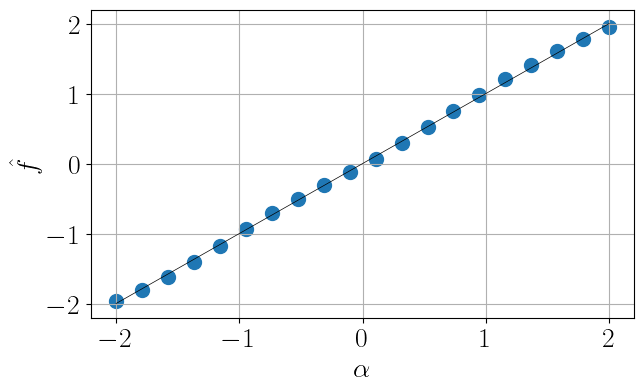

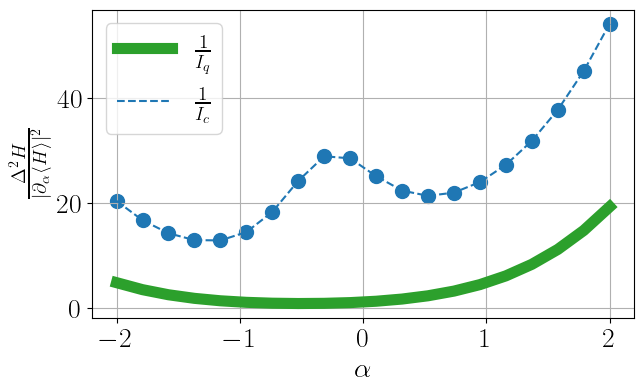

# Schwinger Ham study

In [2]:
def partial_trace(dm, m=None, n=None, subsystem=0):
    """ Simple and fast, but cuts only in halves. """
    if (m is None) or (n is None): # cut in equal halves
        N = log2(len(dm))
        m = int(N / 2)
        n = int(N - m)
        m = 2**m
        n = 2**n
    if subsystem == 0:
        return trace(dm.reshape((m, n, m, n)), axis1=0, axis2=2)
    elif subsystem == 1:
        return trace(dm.reshape((m, n, m, n)), axis1=1, axis2=3)

In [12]:
def qfi_ham_qcnn(ham_func, ham_pars, ham_args, n_inp, n_copies=1, dp=1e-5):

    n_tot = n_inp*n_copies
    d = 2**n_tot
    
    QFIs = []
    for p in ham_pars:        
        ham = ham_func(n_inp, p, *ham_args)
        ham_p = ham_func(n_inp, p+dp, *ham_args)
        ham_m = ham_func(n_inp, p-dp, *ham_args)
        ham_der = (ham_p - ham_m)/(2*dp)

        evals_ham, evecs_ham = eigh(ham)
        e0 = evals_ham[0]
        v0 = evecs_ham[:,0]
        e0_der = (v0.conj().T@ham_der@v0).real # Hellmann-Feynman theorem
        
        mat = ham - e0*eye(2**n_inp)
        mat_der = ham_der - e0_der*eye(2**n_inp) # in literature, the second term is absent for some reason
        
        v0_der = -pinv(mat, rcond=1e-12, hermitian=True)@mat_der@v0 # rcond is important! does not work with the default value
        # v0_der = sum([evecs_ham[:,i].conj().T@ham_der@v0/(evals_ham[i] - e0)*evecs_ham[:,i] for i in range(1, 2**n_inp) if evals_ham[i] - e0 != 0]) # other method, memory-inefficient
    
        v0_der = sum([reduce(kron, [v0]*c + [v0_der] + [v0]*(n_copies - c - 1)) for c in range(n_copies)]) # memory-inefficient, but is a fancy one-liner
        v0 = reduce(kron, [v0]*n_copies)

        QFI = 4*(vdot(v0_der, v0_der) - vdot(v0_der, v0)*vdot(v0, v0_der)).real + 1e-10

        QFIs.append(QFI)  

    return array(QFIs)

In [13]:
def schwinger_ham(N, m, w=1, g=1, e0=0):
    
    d = 2**N
    
    sp = (X + 1j*Y)/2
    sm = (X - 1j*Y)/2
    term_1 = zeros([d, d], dtype=complex)
    for j in range(N - 1):
        op = reduce(kron, [I]*j + [sp, sm] + [I]*(N - j - 2))
        term_1 += op + op.conj().T

    term_2 = zeros([d, d], dtype=complex)
    for j in range(N):
        op = reduce(kron, [I]*j + [Z] + [I]*(N - j - 1))
        term_2 += (-1)**(j + 1)*op

    term_3 = zeros([d, d], dtype=complex)
    for j in range(N):
        L_j = zeros([d, d], dtype=complex)
        for l in range(j + 1):
            op = Z + (-1)**(l + 1)*I
            op = reduce(kron, [I]*l + [op] + [I]*(N - l - 1))
            L_j += op
        L_j = e0 - L_j/2
        term_3 += L_j@L_j
        
    return w*term_1 + m/2*term_2 + g*term_3


def order_par(N):
    d = 2**N
    op = zeros([d, d], dtype=complex)
    for i in range(N):
        Z_i = reduce(kron, [I]*i + [Z] + [I]*(N - i - 1)) * (-1)**(i + 1)
        for j in range(i):
            Z_j = reduce(kron, [I]*j + [Z] + [I]*(N - j - 1)) * (-1)**(j + 1)
            op += (eye(d) + Z_i)@(eye(d) + Z_j)
    return op/(2*N*(N - 1))

In [14]:
def schwinger_ham_other(N, mdg, ag=2, v=pi, s=1):
    """ Taken from https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.5.043250 """
    
    d = 2**N
    
    term_1 = zeros([d, d], dtype=complex)
    for n in range(N): # check!!!!
        term_1_n = zeros([d, d], dtype=complex)
        for i in range(n + 1):
            Z_i = reduce(kron, [I]*i + [Z] + [I]*(N - i - 1))
            eye_i = eye(d)*(-1)**(i + s)
            term_1_n += (Z_i + eye_i)/2
        term_1_n += v/(2*pi)
        term_1 += term_1_n@term_1_n
    
    term_2 = zeros([d, d], dtype=complex)
    for n in range(N - 1):
        term_2 += reduce(kron, [I]*n + [X, X] + [I]*(N - n - 2))
        term_2 += reduce(kron, [I]*n + [Y, Y] + [I]*(N - n - 2))

    term_3 = zeros([d, d], dtype=complex)
    for n in range(N):
        Z_n = reduce(kron, [I]*n + [Z] + [I]*(N - n - 1))
        term_3 += Z_n*(-1)**(n + s)
    
    return ag/2*term_1 + 1/(4*ag)*term_2 + mdg/2*term_3


def order_par_other(N):
    """ Taken from https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.5.043250 """
    d = 2**N
    s = 1
    term_1 = zeros([d, d], dtype=complex)
    for n in range(N): # check!!!!
        term_1_n = zeros([d, d], dtype=complex)
        for i in range(n + 1):
            Z_i = reduce(kron, [I]*i + [Z] + [I]*(N - i - 1))
            eye_i = eye(d)*(-1)**(i + s)
            term_1_n += (Z_i + eye_i)/2
        term_1 += term_1_n@term_1_n
    return term_1/N

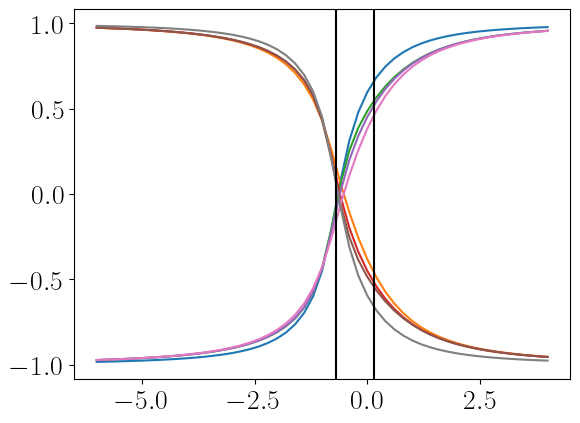

In [15]:
# ham_func = ising_ham; ham_args = []
# ham_func = schwinger_ham_other; ham_args = [2, pi, 0]
ham_func = schwinger_ham; ham_args = [1, 1, 0] # 1/(2*pi)

n_inp = 8
a = -6
b = 4
T = 11
V = 51

labels_train = linspace(a, b, T)
# labels_train = np.sort(uniform(a, b, 20))
svs_train = []
for p in labels_train:
    print(p, end="\r")
    ham = ham_func(n_inp, p, *ham_args)
    svs_train.append(eigh(ham)[1][:,0])

labels_test = linspace(a, b, V)
svs_test = []
for p in labels_test:
    print(p, end="\r")
    ham = ham_func(n_inp, p, *ham_args)
    svs_test.append(eigh(ham)[1][:,0])

# plt.scatter(labels_train, labels_train)

z_expecs = []
for q in range(n_inp):
    # print("I"*q + "Z" + "I"*(n_inp - q - 1))
    obs_q = reduce(kron, [I]*q + [Z] + [I]*(n_inp - q - 1))
    z_expecs_q = []
    for i in range(V):
        dm = outer(svs_test[i], svs_test[i].conj().T)
        expec = trace(dm@obs_q).real
        z_expecs_q.append(expec)
    z_expecs.append(z_expecs_q)

for q in range(n_inp):
    plt.plot(labels_test, z_expecs[q])
plt.axvline(0.143, color="black")
plt.axvline(-0.7, color="black")
plt.show()

In [16]:
vn_ents = []
lambdas_gs = []
for i in range(V):
    print(i, end="\r")
    dm = outer(svs_test[i], svs_test[i].conj().T)
    dm_red = partial_trace(dm, 2**3, 2**5)
    # dm_gs_red = partial_trace_general(dm_gs, [i for i in range(int(N/2))])
    vn_ents.append(-trace(dm_red@logm(dm_red)).real)
    lambdas_gs.append(eigh(dm_red)[0][::-1])

/home/kardashin/anaconda3/lib/python3.11/site-packages/scipy/linalg/_matfuncs.py:200: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  F = scipy.linalg._matfuncs_inv_ssq._logm(A)


In [18]:
QFIs_test = qfi_ham_qcnn(ham_func, labels_test, ham_args, n_inp, dp=1e-3)

opar = order_par(n_inp)
opar_proper = order_par_proper(n_inp)
opar_vals = []
opar_vals_proper = []
for i in range(V):
    print(i, end="\r")
    dm = outer(svs_test[i], svs_test[i].conj().T)
    opar_vals.append(trace(dm@opar).real)
    opar_vals_proper.append(trace(dm@opar_proper).real)

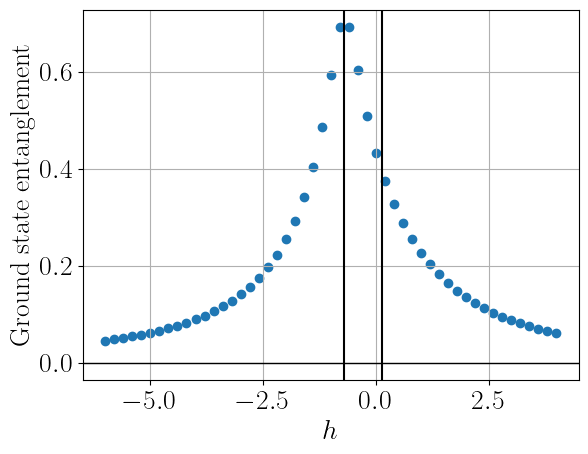

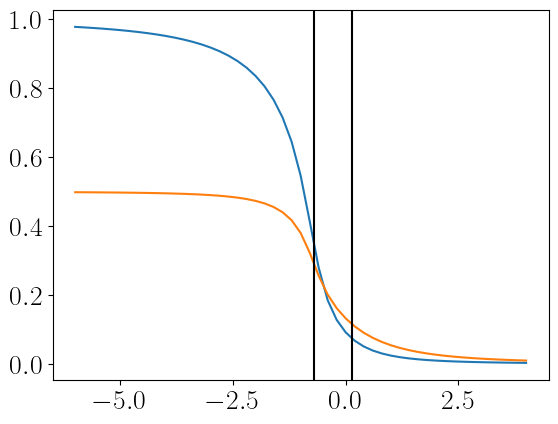

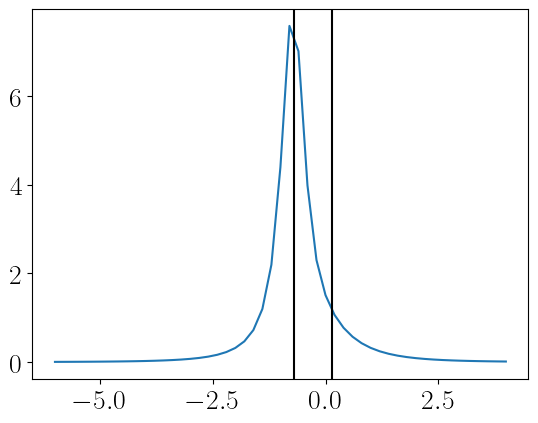

In [20]:
plt.scatter(labels_test, vn_ents)
plt.axhline(0, color="black", linewidth=1)
plt.axvline(0.143, color="black")
plt.axvline(-0.7, color="black")
plt.xlabel(r"$h$")
plt.ylabel(r"Ground state entanglement")
# plt.yscale("log")
plt.grid()
plt.show()

# for i in range(2**int(N/2)):
# for i in range(2):#2**int(N/2)):
#     plt.scatter(labels_test, array(lambdas_gs).T[i])
# plt.axvline(0.143, color="black")
# plt.xlabel(r"$h$")
# plt.ylabel(r"$\lambda^2$")
# plt.yscale("log")
# plt.show()

plt.plot(labels_test, opar_vals)
plt.plot(labels_test, opar_vals_proper)
plt.axvline(0.143, color="black")
plt.axvline(-0.7, color="black")
plt.show()

plt.plot(labels_test, QFIs_test)
plt.axvline(0.143, color="black")
plt.axvline(-0.7, color="black")
plt.show()

# Old code

## More efficient and a bit faster, but allows to measure only adjacent qubits

In [136]:
def train_qcnn(svs, labels, n_copies=1, method="BFGS", w_ls=1e0, w_var=1e-4, x0=None, options={}, save_data=False, file_name=None, fvals=[]):

    n_inp = int(log2(len(svs[0]))) # number of qubits
    n_tot = n_inp*n_copies # total number of qubits
    d = 2**n_tot 
    d_diff = 2**(n_tot - 1) # legacy
    
    n_pars_est = 2 # number of eigenvalues x_i
    n_pars_ans = sum([15*n_tot//dd + 15*(n_tot//dd - 1) + 6*n_tot//dd for dd in [2**q for q in range(1, int(log2(n_tot)) + 1)]]) # number of ansatz parameters theta_i 
    
    svs_cop = [reduce(kron, [sv]*n_copies) for sv in svs] # if process copies

    fval_cont = [0]
    
    def fun(x):
        x_ans, x_est = x[:n_pars_ans], x[n_pars_ans:] # parameters x_i and theta_i
        U = qcnn_schwinger(n_tot, x_ans) # unitary of the QCNN
        H_u = (U.conj().T*kron_A_I_diag(x_est, d_diff))@U # compose the prove observable
        expecs = zeros(len(labels))
        disps = zeros(len(labels))
        for j in range(len(labels)):
            H_u_v0 = H_u@svs_cop[j]
            expecs[j] = (svs_cop[j].conj().T@H_u_v0).real # expectation of H
            disps[j] = (H_u_v0.conj().T@H_u_v0).real # expectation of H^2
        f = w_ls*np.sum((expecs - labels)**2) # least squares
        f += w_var*np.sum(disps - expecs**2) # sum of variances
        fval_cont[0] = f
        return f

    if save_data == True and file_name is None:
        file_name = "pars-c=%d-l=%d-w_ls=%f-w_var=%f-n_train=%d" %(n_copies, n_layers, w_ls, w_var, len(labels))
    
    time_loc = time()
    
    def callback(x):
        fvals.append(fval_cont[0])
        print("\t\t\tIteration: %d | Cost: %.8f | Time passed: %d s" %(len(fvals), fval_cont[0], time() - time_loc), end="\r")
        if save_data == True:
            np.save(file_name, x)
        return None
    
    if method in ["Nelder-Mead", "L-BFGS-B", "SLSQP", "TNC", "Powell", "COBYLA"]:
        bounds = [(0, 2*pi)]*n_pars_ans + [(None, None)]*n_pars_est
    else:
        bounds = None
    if x0 is None:
        x0_ans = normal(pi/4, 1, n_pars_ans)
        x0_est = normal(0, 0.1, n_pars_est)
        x0 = concatenate([x0_ans, x0_est])
    
    optimization_result = minimize(fun=fun, x0=x0, callback=callback, bounds=bounds, method=method, options=options)

    return fvals, optimization_result

In [135]:
def aux_info_qcnn(ham_func, ham_pars, ham_args, n_inp, pars, n_copies=1, dp=1e-5):
    """
        ham_func --- function for generating the Hamiltonian; the first argument is the number of qubits n_inp, the second is the parameter (i.e., transverse field in the Ising Hamiltonian)
        ham_pars --- list of the Hamiltonian parameters (i.e., list of the transverse field values)
        ham_args --- list of the rest Hamiltonain arguments (can be empty, [])
        n_inp --- number of qubits
        pars --- parameters of the ansatz
    """
    
    n_tot = n_inp*n_copies
    d = 2**n_tot
    
    pars_ans = pars[:-2]
    pars_est = pars[-2:]

    # ansatz = qcnn_schwinger(n_tot, pars_ans) # variational ansatz 
    # projs = [reduce(kron, [diag(line), eye(2**(n_tot - 1))]) for line in eye(2)] # eigenprojectors of the observable for the last measured qubit
    # projs_u = [ansatz.conj().T@proj@ansatz for proj in projs] # rotated eigenprojectors
    # HHH = sum([x_i*proj_i for x_i, proj_i in zip(pars_est, projs_u)]) 
    
    ### retarded ###
    d_diff = 2**(n_tot - 1) # legacy
    U = qcnn_schwinger(n_tot, pars_ans) # variational ansatz
    H_u = (U.conj().T*kron_A_I_diag(pars_est, d_diff))@U # compose the prove observable
    eigsys = eigh(H_u)
    projs_u = [outer(eigvec, eigvec.conj().T) for eigvec in eigsys[1].T]
    pars_est = eigsys[0]

    v0s = []
    v0s_der = []
    QFIs = []
    for p in ham_pars:        
        ham = ham_func(n_inp, p, *ham_args)
        ham_p = ham_func(n_inp, p+dp, *ham_args)
        ham_m = ham_func(n_inp, p-dp, *ham_args)
        ham_der = (ham_p - ham_m)/(2*dp)

        evals_ham, evecs_ham = eigh(ham)
        e0 = evals_ham[0]
        v0 = evecs_ham[:,0]
        e0_der = (v0.conj().T@ham_der@v0).real # Hellmann-Feynman theorem
        
        mat = ham - e0*eye(2**n_inp)
        mat_der = ham_der - e0_der*eye(2**n_inp) # in literature, the second term is absent for some reason
        
        v0_der = -pinv(mat, rcond=1e-12, hermitian=True)@mat_der@v0 # rcond is important! does not work with the default value
        # v0_der = sum([evecs_ham[:,i].conj().T@ham_der@v0/(evals_ham[i] - e0)*evecs_ham[:,i] for i in range(1, 2**n_inp) if evals_ham[i] - e0 != 0]) # other method, memory-inefficient
        
        ### checks; should be zeros ###
        # print(norm(mat_der@v0 + mat@v0_der))
        # print(norm((ham_der@v0 + ham@v0_der) - (e0_der*v0 + e0*v0_der)))
        # print()
    
        v0_der = sum([reduce(kron, [v0]*c + [v0_der] + [v0]*(n_copies - c - 1)) for c in range(n_copies)]) # memory-inefficient, but is a fancy one-liner
        v0 = reduce(kron, [v0]*n_copies)

        QFI = 4*(vdot(v0_der, v0_der) - vdot(v0_der, v0)*vdot(v0, v0_der)).real + 1e-10

        v0s.append(v0)
        v0s_der.append(v0_der)
        QFIs.append(QFI)  

    expecs = []
    expecs_der = []
    disps = []
    CFIs = []
    for j in range(len(ham_pars)): 
        probs = [(v0s[j].conj().T@proj@v0s[j]).real for proj in projs_u]
        probs_der = [2*(v0s_der[j].conj().T@proj@v0s[j]).real for proj in projs_u]
        
        expec = sum([ev*prob for ev, prob in zip(pars_est, probs)])
        expec_der = sum([ev*prob_der for ev, prob_der in zip(pars_est, probs_der)])
        disp = sum([ev**2*prob for ev, prob in zip(pars_est, probs)]) - expec**2
        
        CFI = sum([prob_der**2/prob if prob > 0 else 0 for prob_der, prob in zip(probs_der, probs)]) + 1e-10
        
        expecs.append(expec)
        expecs_der.append(expec_der)
        disps.append(disp)
        CFIs.append(CFI)
    
    return array(expecs), array(expecs_der), array(disps), array(CFIs), array(QFIs)

# some crap

In [60]:
II = kron(I, I)
XX = kron(X, X)
YY = kron(Y, Y)
ZZ = kron(Z, Z)

pars = uniform(0, 2*pi, 3)

c0, s0 = cos(pars[0]), sin((pars[0]))
c1, s1 = cos(pars[1]), sin((pars[1]))
c2, s2 = cos(pars[2]), sin((pars[2]))

op1 = (c0*c1*c2 - 1j*s0*s1*s2)*II \
    + (c0*s1*s2 - 1j*s0*c1*c2)*XX \
    + (s0*c1*s2 - 1j*c0*s1*c2)*YY \
    + (s0*s1*c2 - 1j*c0*c1*s2)*ZZ

op2 = expm(-1j*(pars[0]*XX + pars[1]*YY + pars[2]*ZZ))

op3 = rzzyyxx(2, 0, 1, pars)

print(abs(trace(op1@op2.conj().T)))
print(abs(trace(op2@op3.conj().T)))
print(abs(trace(op1@op3.conj().T)))
print(norm(op1 - op2))
print(norm(op2 - op3))
print(norm(op1 - op3))

4.0
4.0
4.0
6.928130270064997e-16
6.928130270064997e-16
0.0


## Just a bit faster and more efficient way of computing the diagonal observable

In [43]:
n_tot = 8
d = 2**n_tot
n_meas_list = [0, 1, 2, 3, 4, 5, 6, 7]
x_est = arange(1, 2*len(n_meas_list) + 1)

temp = ["ph" if q in n_meas_list else "_" for q in range(n_tot)]
H_pre = []
ph_inds = []
i = 0
q = 0
while q < n_tot:
    c = 0
    if temp[q] == "ph":
        H_pre.append("ph")
        ph_inds.append(i)
        q += 1
        i += 1
    elif temp[q] == "_":
        while q < n_tot:
            if temp[q] == "_":
                q += 1
                c += 1
            else:
                break
    if c > 0:
        H_pre.append(ones(2**c))
        i += 1
print(temp)
print(ph_inds)
H_pre

for q in range(len(ph_inds)):
    H_pre[ph_inds[q]] = x_est[2*q : 2*(q + 1)]
ham2 = reduce(fkron_diag, H_pre)
ham2

['ph', 'ph', 'ph', 'ph', 'ph', 'ph', 'ph', 'ph']
[0, 1, 2, 3, 4, 5, 6, 7]


array([ 2027025,  2162160,  2182950,  2328480,  2211300,  2358720,
        2381400,  2540160,  2252250,  2402400,  2425500,  2587200,
        2457000,  2620800,  2646000,  2822400,  2316600,  2471040,
        2494800,  2661120,  2527200,  2695680,  2721600,  2903040,
        2574000,  2745600,  2772000,  2956800,  2808000,  2995200,
        3024000,  3225600,  2432430,  2594592,  2619540,  2794176,
        2653560,  2830464,  2857680,  3048192,  2702700,  2882880,
        2910600,  3104640,  2948400,  3144960,  3175200,  3386880,
        2779920,  2965248,  2993760,  3193344,  3032640,  3234816,
        3265920,  3483648,  3088800,  3294720,  3326400,  3548160,
        3369600,  3594240,  3628800,  3870720,  2702700,  2882880,
        2910600,  3104640,  2948400,  3144960,  3175200,  3386880,
        3003000,  3203200,  3234000,  3449600,  3276000,  3494400,
        3528000,  3763200,  3088800,  3294720,  3326400,  3548160,
        3369600,  3594240,  3628800,  3870720,  3432000,  3660

In [ ]:
n_tot = 8
n_meas_list = [0, 1, 2, 3, 4, 5, 6, 7]

temp = ["ph" if q in n_meas_list else "_" for q in range(n_tot)]
H_pre = []
q = 0
while q < n_tot:
    c = 0
    if temp[q] == "ph":
        H_pre.append("ph")
        ph_inds.append(i)
        q += 1
    elif temp[q] == "_":
        while q < n_tot:
            if temp[q] == "_":
                q += 1
                c += 1
            else:
                break
    if c > 0:
        H_pre.append(ones(2**c))
        i += 1